In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
    %tensorflow_version 2.x  # Colab only.
except Exception:
    pass

import tensorflow as tf
print(tf.__version__)

2.3.1


In [2]:
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

This is a time series of the form:

$$ x(t) = \sin(\omega t^2) $$

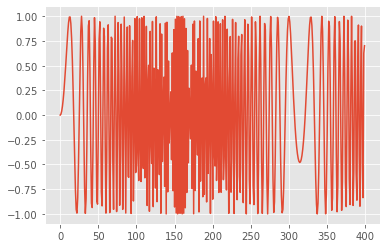

In [5]:
# make the original data
series = np.sin((0.1*np.arange(400))**2)    # 0.1 is angular frequency

# plot it
plt.plot(series)
plt.show()

- N = number of samples
- T = sequence length
- D = number of input features
- M = number of hidden units
- K = number of output units

In [6]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10    # which means we going to use 10 previous timestamps to predict the next timestamps
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T) # make it N x T
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (390, 10) Y.shape (390,)


In [7]:
### try autoregressive LINEAR MODEL
i = Input(shape=(T,))
x = Dense(1)(i)
model = Model(i, x)
model.compile(loss='mse', 
              optimizer=Adam(lr=0.01))

# train the RNN
r = model.fit(X[:-N//2], Y[:-N//2], 
              epochs=80, 
              validation_data=(X[-N//2:], Y[-N//2:]))

Epoch 1/80
7/7 [==============================] - 0s 22ms/step - loss: 0.7807 - val_loss: 0.7641
Epoch 2/80
7/7 [==============================] - 0s 5ms/step - loss: 0.6781 - val_loss: 0.7447
Epoch 3/80
7/7 [==============================] - 0s 5ms/step - loss: 0.6072 - val_loss: 0.7254
Epoch 4/80
7/7 [==============================] - 0s 4ms/step - loss: 0.5643 - val_loss: 0.6976
Epoch 5/80
7/7 [==============================] - 0s 4ms/step - loss: 0.5403 - val_loss: 0.6761
Epoch 6/80
7/7 [==============================] - 0s 4ms/step - loss: 0.5213 - val_loss: 0.6530
Epoch 7/80
7/7 [==============================] - 0s 4ms/step - loss: 0.5112 - val_loss: 0.6380
Epoch 8/80
7/7 [==============================] - 0s 5ms/step - loss: 0.5031 - val_loss: 0.6246
Epoch 9/80
7/7 [==============================] - 0s 4ms/step - loss: 0.4977 - val_loss: 0.6138
Epoch 10/80
7/7 [==============================] - 0s 4ms/step - loss: 0.4948 - val_loss: 0.6080
Epoch 11/80
7/7 [=====================

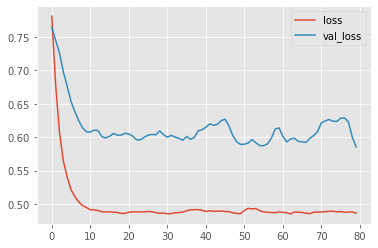

In [8]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(390, 1)


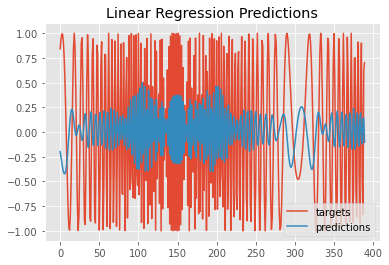

In [15]:
# One-step forecast using true targets
# Note: even the one-step forecast fails badly
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("Linear Regression Predictions")
plt.legend()
plt.show()

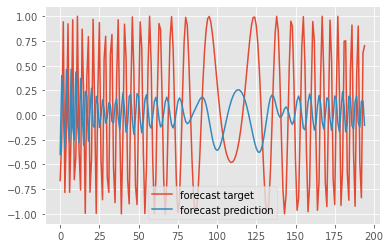

In [16]:
# This is the code we had before - it does the same thing

# One-step forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
    p = model.predict(X[i].reshape(1, -1))[0,0] # 1x1 array -> scalar
    i += 1

    # update the predictions list
    validation_predictions.append(p)

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

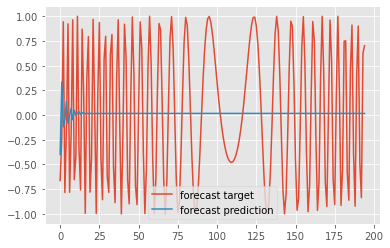

In [17]:
# Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, -1))[0,0] # 1x1 array -> scalar

    # update the predictions list
    validation_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [20]:
### Now try RNN/LSTM model
X = X.reshape(-1, T, D) # make it N x T x D

# make the RNN
i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.05),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  batch_size=32,
  epochs=200,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/200
7/7 [==============================] - 1s 102ms/step - loss: 0.5362 - val_loss: 0.5233
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 0.5171 - val_loss: 0.5139
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 0.4970 - val_loss: 0.5511
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 0.4790 - val_loss: 0.5964
Epoch 5/200
7/7 [==============================] - 0s 8ms/step - loss: 0.4022 - val_loss: 0.4932
Epoch 6/200
7/7 [==============================] - 0s 9ms/step - loss: 0.3196 - val_loss: 0.4259
Epoch 7/200
7/7 [==============================] - 0s 8ms/step - loss: 0.2375 - val_loss: 0.4822
Epoch 8/200
7/7 [==============================] - 0s 8ms/step - loss: 0.1968 - val_loss: 0.3082
Epoch 9/200
7/7 [==============================] - 0s 10ms/step - loss: 0.1252 - val_loss: 0.2297
Epoch 10/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0845 - val_loss: 0.1721
Epoch 11/200
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0748
Epoch 85/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0752
Epoch 86/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0763
Epoch 87/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0731
Epoch 88/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0758
Epoch 89/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0836
Epoch 90/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0752
Epoch 91/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0719
Epoch 92/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0716
Epoch 93/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0734
Epoch 94/200
7/7 [===============

7/7 [==============================] - 0s 8ms/step - loss: 6.2384e-04 - val_loss: 0.0633
Epoch 167/200
7/7 [==============================] - 0s 8ms/step - loss: 8.3883e-04 - val_loss: 0.0655
Epoch 168/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0600
Epoch 169/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0602
Epoch 170/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0625
Epoch 171/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0010 - val_loss: 0.0615
Epoch 172/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0640
Epoch 173/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0643
Epoch 174/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0602
Epoch 175/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0663
Epoch 176/200
7/

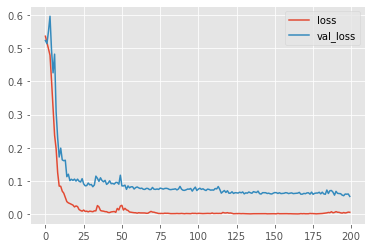

In [21]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

(390, 1)


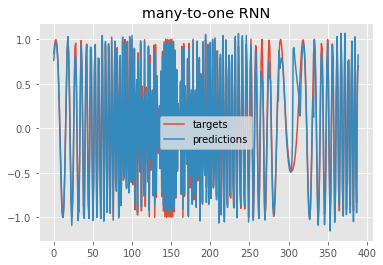

In [22]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.title("many-to-one RNN")
plt.legend()
plt.show()

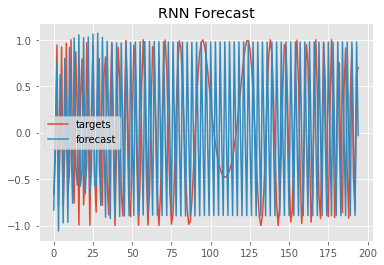

In [23]:
# Multi-step forecast
forecast = []
input_ = X[-N//2]
while len(forecast) < len(Y[-N//2:]):
    # Reshape the input_ to N x T x D
    f = model.predict(input_.reshape(1, T, 1))[0,0]
    forecast.append(f)

    # make a new input with the latest forecast
    input_ = np.roll(input_, -1)
    input_[-1] = f

plt.plot(Y[-N//2:], label='targets')
plt.plot(forecast, label='forecast')
plt.title("RNN Forecast")
plt.legend()
plt.show()